### Task 2. Relationship between diversity of a user's activity and the diversity of the recommended items

In this notebook:
- $RMSDE$ and $R^2$ is computed for all the prediction types and saved in the corresponding result_experiments folder as `rmsde_r2_scores.tex`
- $ILD$ distribution plot is generated and saved in the corresponding result_experiments folder as `ild_plot.png`, as well as merged `ild_plot`, directly in the result_experiments folder.
- $RMSDE$ and $R^2$ is computed between user diversities of user profile and unexpectedness of the recommended items and saved in the corresponding result_experiments folder as `rmsde_r2_unexpectedness_scores.png`.

#### Imports

In [34]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Markdown

from Conferences.SIGIR.CMN_our_interface.CiteULike.CiteULikeReader import (
    CiteULikeReader
)
from Conferences.RecSys.SpectralCF_our_interface.Movielens1M.Movielens1MReader import Movielens1MReader
from Conferences.RecSys.SpectralCF_our_interface.AmazonInstantVideo.AmazonInstantVideoReader import AmazonInstantVideoReader
from Base.Evaluation.Evaluator import Evaluator
from Base.Similarity.Compute_Similarity import Compute_Similarity
from Base.Evaluation.metrics import unexpectedness

#### Helpers

In [35]:
def load_dataset(dataset_name, conf_name, algorithm_name):
    result_folder_path = 'result_experiments/{}/{}_{}/'.format(
        conf_name, algorithm_name, dataset_name
    )
    os.makedirs(result_folder_path, exist_ok=True)

    if dataset_name == 'citeulike':
        dataset = CiteULikeReader(result_folder_path)
    elif dataset_name == 'movielens1m_ours':
        dataset = Movielens1MReader(result_folder_path, type ='ours')
    elif dataset_name == 'amazon_instant_video':
        dataset = AmazonInstantVideoReader(result_folder_path)
    else:
        raise RuntimeError(f'Unsupported dataset: {dataset_name}')

    URM_train = dataset.URM_DICT['URM_train'].copy()
    URM_validation = dataset.URM_DICT['URM_validation'].copy()
    URM_test = dataset.URM_DICT['URM_test'].copy()

    users_to_evaluate = Evaluator(URM_test, cutoff_list=[50]).users_to_evaluate

    URM_train = URM_train[users_to_evaluate]
    URM_validation = URM_validation[users_to_evaluate]
    URM_test = URM_test[users_to_evaluate]

    return URM_train, URM_validation, URM_test

In [36]:
def intra_list_diversity(items, items_similarity_matrix):
    n = len(items)

    if n < 2:
        # It could be items_similarity[items[0], items[0]]
        return 0

    items_similarity = items_similarity_matrix[items][:, items]
    similarity = np.triu(1 - items_similarity.todense(), 1).sum()
    diversity = 2 * similarity / (n * (n - 1))
    return diversity

def diversity(users_data, items_similarity_matrix):
    return np.array(
        [intra_list_diversity(user_list.indices, items_similarity_matrix) for user_list in users_data]
    )

def predictions_to_csr_matrix(predictions):
    column = predictions.reshape((predictions.shape[0] * predictions.shape[1]))

    rows = [[i] * predictions.shape[1] for i in range(predictions.shape[0])]
    rows = np.array(rows)
    rows = rows.reshape((column.shape))

    data = np.ones(rows.shape)
    return sparse.csr_matrix((data, (rows, column)), dtype = np.int8)

def rmsde(ground_truth_diversity, predicted_diversity):
    return np.sqrt(np.mean((np.square(ground_truth_diversity - predicted_diversity))))

def r_squared(ground_truth_diversity, predicted_diversity):
    r_score = np.sum(np.square(ground_truth_diversity - predicted_diversity))
    r_score /= np.sum(np.square(ground_truth_diversity - np.mean(ground_truth_diversity)))

    return 1 - r_score

In [37]:
def get_user_relevant_items(URM_test, user_id):
    return URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

In [38]:
def get_user_unexpectedness(URM_test, predicted_data):
    user_unexpectedness = []
    for user_id in range(predicted_data.shape[0]):
        reccomended_items = predicted_data[user_id]
        relevant_items = get_user_relevant_items(URM_test, user_id)
        user_unexpectedness.append(unexpectedness(
                    URM_test,
                    reccomended_items,
                    relevant_items,
                ).mean())

    return user_unexpectedness

### Compute RMSDE, R2 and ILD data

In [39]:
experiments_metadata = [
    {
        "conf_name": "SIGIR",
        "algorithm_name": "CMN",
        "datasets": ["citeulike"]
    },
    {
        "conf_name": "RecSys",
        "algorithm_name": "SpectralCF",
        "datasets": ["movielens1m_ours", "amazon_instant_video"]
    }
]

In [40]:
def compute_diversity_results(conf_name, algorithm_name, dataset_name):
    algorithm_name = algorithm_name.replace('_RecommenderWrapper', "").replace("Recommender", "")
    path_to_results = f'result_experiments/{conf_name}/{algorithm_name}_{dataset_name}/'
    URM_train, URM_test, URM_validation = load_dataset(dataset_name, conf_name, algorithm_name)
    items_similarity_matrix = Compute_Similarity(URM_train, similarity="cosine").compute_similarity()
    URM_train_diversity = diversity(URM_train, items_similarity_matrix)
    


    results_dict = {
        'conf_name': conf_name,
        'algorithm_name': algorithm_name,
        'dataset_name': dataset_name,
        'algorithm': ['User profile', ],
        'diversity': [URM_train_diversity, ],
        'user_ILD': [np.mean(URM_train_diversity), ],  
        'recommender_ILD': [],  
        'RMSDE': [0, ],
        'RMSDE unexpectedness': [0, ],
        'R^2': [0, ],
        'R^2 unexpectedness': [0, ],
    }

    for file_name in os.listdir(path_to_results):
        if file_name.endswith('.csv'):
            algorithm = file_name.split('.')[0]
            results_dict['algorithm'].append(algorithm)

            data = pd.read_csv(os.path.join(path_to_results, file_name))
            predicted_data = data.to_numpy()[:, 1:11]

            prediction_matrix = predictions_to_csr_matrix(predicted_data)
            predicted_diversity = diversity(prediction_matrix, items_similarity_matrix)


            unexpectedness = get_user_unexpectedness(URM_train, predicted_data)
            results_dict['diversity'].append(predicted_diversity)
            results_dict['RMSDE'].append(rmsde(URM_train_diversity, predicted_diversity))
            results_dict['R^2'].append(r_squared(URM_train_diversity, predicted_diversity))

            results_dict['RMSDE unexpectedness'].append(rmsde(URM_train_diversity, unexpectedness))
            results_dict['R^2 unexpectedness'].append(r_squared(URM_train_diversity, unexpectedness))
            results_dict['diversity'].append(predicted_diversity)
            results_dict['recommender_ILD'].append(np.mean(predicted_diversity))

    return results_dict


results = []
for experiment in experiments_metadata:
    for dataset_name in experiment["datasets"]:
        conf_name = experiment["conf_name"]
        algorithm_name = experiment["algorithm_name"]
        results.append(compute_diversity_results(conf_name, algorithm_name, dataset_name))

CiteULikeReader: Attempting to load pre-splitted data
CiteULikeReader: Dataset loaded
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 16980 (100.0%), 4200.18 column/sec. Elapsed time 4.04 sec
Dataset_Movielens1M: Attempting to load pre-splitted data
Dataset_Movielens1M: Dataset loaded
DATASET   -> users: 6039 	items: 3882 	ratings:   225473 	density: 0.962%
URM_train -> users: 6039 	items: 3882 	ratings:   161797 	density: 0.690%
URM_test  -> users: 6039 	items: 3882 	ratings:    45200 	density: 0.193%
URM_validation-> users: 6039 	items: 3882 	ratings:    18476 	density: 0.079%
Evaluator_Base_Class: Ignoring 5960 ( 1.3%) Users that have less than 1 test interactions
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 3882 (100.0%), 7620.83 column/sec. Elapsed time 0.51 sec
Dataset_AmazonInstantVideo: Attempting to load pre-splitted data
Dataset_AmazonInstantVideo: Dataset loaded
DATASET   -> users: 3113 	items: 5860 	ratings:

#### $RMSDE$ and $R^2$ results

In [41]:
path_to_results_template = 'result_experiments/{}/{}_{}/rmsde_r2_scores.tex'

for result in results:
    scores = pd.DataFrame({
            'User Profile ILD': result['user_ILD'][0],  
            'Recommender ILD': result['recommender_ILD'],
            'RMSDE': result['RMSDE'][1:],
            'R^2': result['R^2'][1:]   
        }, index=result['algorithm'][1:])

    display(Markdown(f'### {result["conf_name"]} | {result["dataset_name"]} results'))
    display(scores)

    
    scores.to_latex(path_to_results_template.format(result["conf_name"], result["algorithm_name"], result["dataset_name"]))

### SIGIR | citeulike results

,User Profile ILD,Recommender ILD,RMSDE,R^2
CMN_RecommenderWrapper,0.875583,0.993511,0.163780,-1.053004
ItemKNNCFRecommender,0.875583,0.991919,0.163017,-1.033943
P3alphaRecommender,0.875583,0.992902,0.163544,-1.047109
RP3betaRecommender,0.875583,0.992882,0.163497,-1.045926
SLIMElasticNetRecommender,0.875583,0.993490,0.163859,-1.054989
TopPopRecommender,0.875583,0.993279,0.163963,-1.057604
UserKNNCFRecommender,0.875583,0.992604,0.163437,-1.044431


### RecSys | movielens1m_ours results

,User Profile ILD,Recommender ILD,RMSDE,R^2
ItemKNNCFRecommender,0.907773,0.787822,0.215982,-0.619658
P3alphaRecommender,0.907773,0.774742,0.217957,-0.649423
RP3betaRecommender,0.907773,0.772134,0.223229,-0.730171
SLIMElasticNetRecommender,0.907773,0.816174,0.199032,-0.375422
SpectralCF_RecommenderWrapper,0.907773,0.854549,0.176682,-0.083862
TopPopRecommender,0.907773,0.729803,0.245340,-1.089900
UserKNNCFRecommender,0.907773,0.807670,0.210067,-0.532163


### RecSys | amazon_instant_video results

,User Profile ILD,Recommender ILD,RMSDE,R^2
ItemKNNCFRecommender,0.739603,0.966863,0.316932,-0.965935
P3alphaRecommender,0.739603,0.966241,0.315327,-0.946072
RP3betaRecommender,0.739603,0.964700,0.313009,-0.917575
SLIMElasticNetRecommender,0.739603,0.965736,0.314933,-0.941213
SpectralCF_RecommenderWrapper,0.739603,0.981059,0.330932,-1.143457
TopPopRecommender,0.739603,0.959495,0.315117,-0.943480
UserKNNCFRecommender,0.739603,0.966860,0.316933,-0.965950


### ILD distribution plot

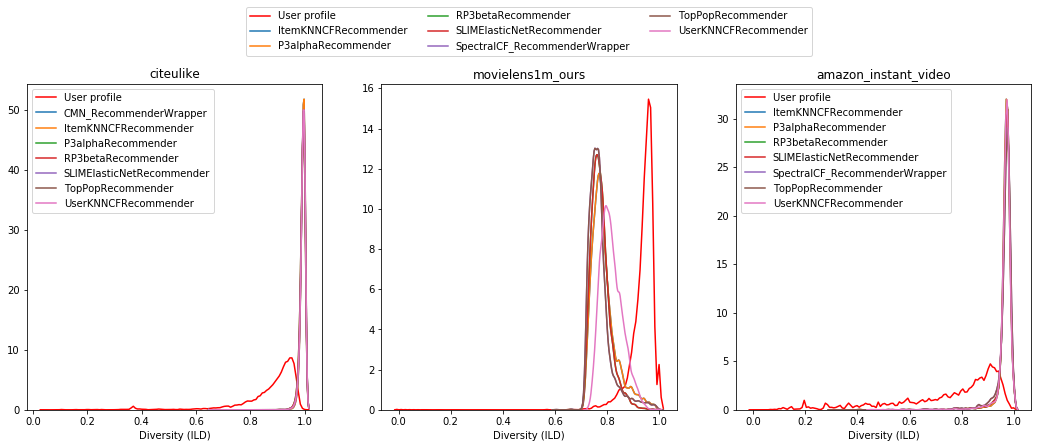

In [42]:
path_to_results_template = 'result_experiments/{}/{}_{}/rmsde_r2_scores.tex'
num_plots = len(results)

fig, axes = plt.subplots(1, num_plots, figsize=(18, 6))

for i, result in enumerate(results):
    for diversity_data, algorithm in zip(result["diversity"], result["algorithm"]):
        color = 'red' if algorithm == 'User profile' else None
        sns.kdeplot(diversity_data, label=algorithm, color=color, ax=axes[i], bw=0.005)  


    axes[i].set_title(result["dataset_name"])
    axes[i].set_xlabel('Diversity (ILD)')
    axes[i].set_ylabel('')

axes[1].legend(bbox_to_anchor=(0.5, 1.25), loc='upper center', ncol=3)



#### $RMSDE$ and $R^2$ unexpectedness results

In [10]:
path_to_results_template = 'result_experiments/{}/{}_{}/rmsde_r2_unexpectedness_scores.tex'

for result in results:
    scores = pd.DataFrame({
            'RMSDE unexpectedness': result['RMSDE unexpectedness'][1:],
            'R^2 unexpectedness': result['R^2 unexpectedness'][1:]
        }, index=result['algorithm'][1:])

    display(Markdown(f'### {result["conf_name"]} | {result["dataset_name"]} results'))
    display(scores)

    scores.to_latex(path_to_results_template.format(result["conf_name"], result["algorithm_name"], result["dataset_name"]))

### SIGIR | citeulike results

,RMSDE unexpectedness,R^2 unexpectedness
CMN_RecommenderWrapper,0.777868,-45.310863
ItemKNNCFRecommender,0.761004,-43.324514
P3alphaRecommender,0.765071,-43.799560
RP3betaRecommender,0.764617,-43.746400
SLIMElasticNetRecommender,0.763137,-43.573428
TopPopRecommender,0.842305,-53.301179
UserKNNCFRecommender,0.761079,-43.333276


### RecSys | movielens1m_ours results

,RMSDE unexpectedness,R^2 unexpectedness
ItemKNNCFRecommender,0.774231,-19.812793
P3alphaRecommender,0.788536,-20.589006
RP3betaRecommender,0.782740,-20.272799
SLIMElasticNetRecommender,0.778689,-20.053187
SpectralCF_RecommenderWrapper,0.853647,-24.301518
TopPopRecommender,0.833321,-23.110917
UserKNNCFRecommender,0.787131,-20.512111


### RecSys | amazon_instant_video results

,RMSDE unexpectedness,R^2 unexpectedness
ItemKNNCFRecommender,0.686487,-8.223647
P3alphaRecommender,0.681597,-8.092689
RP3betaRecommender,0.679130,-8.027013
SLIMElasticNetRecommender,0.684057,-8.158451
SpectralCF_RecommenderWrapper,0.743440,-9.817559
TopPopRecommender,0.741477,-9.760515
UserKNNCFRecommender,0.686489,-8.223691
